In [1]:
import pdfminer
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('phishing_site_urls.csv')

df.columns = [x.lower() for x in df.columns]
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)



In [3]:
def url_process(url):
    url = re.sub('[^a-zA-Z\ \n]', '.', url.lower())
    url =  re.sub('\.{1,}', ' ', url)
    url = url.split(' ')
    
    stemmer = SnowballStemmer("english")
    url = [stemmer.stem(word) for word in url]
    url = ' '.join(url)
    return url

df['url_clean'] = df['url'].apply(url_process)

In [4]:
cv=CountVectorizer(ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(df['url_clean'], df['Y'], test_size=0.2, random_state=5555)

cv_fit = cv.fit(X_train)
X_train = cv_fit.transform(X_train)

X_test = cv_fit.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

lg = LogisticRegression(C=10, penalty='l2', solver='lbfgs')
nb = MultinomialNB(alpha= 0.1, class_prior= None, fit_prior=True)
svm = LinearSVC(C=1)

max_model = VotingClassifier(estimators=[('LogisticsRegression',lg),
                                        ('NultinomialNB',nb),
                                        ('SVM',svm)],
                                        voting='hard')
max_model.fit(X_train,y_train)

max_model.score(X_test,y_test)

0.9832711386183671

In [6]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test,max_model.predict(X_test)))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     78641
           1       0.98      0.96      0.97     31229

    accuracy                           0.98    109870
   macro avg       0.98      0.98      0.98    109870
weighted avg       0.98      0.98      0.98    109870




CONFUSION MATRIX


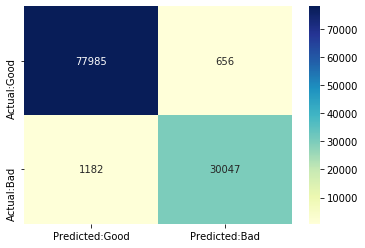

In [7]:
con_mat = pd.DataFrame(confusion_matrix(y_test,max_model.predict(X_test)),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")